# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Инструкция по выполнению проекта

1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Обучите и проверьте модель для каждого региона:
 - Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
 - Обучите модель и сделайте предсказания на валидационной выборке.
 - Сохраните предсказания и правильные ответы на валидационной выборке.
 - Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
 - Проанализируйте результаты.
3. Подготовьтесь к расчёту прибыли:
 - Все ключевые значения для расчётов сохраните в отдельных переменных.
 - Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 
 - Напишите выводы по этапу подготовки расчёта прибыли.
4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 - Выберите скважины с максимальными значениями предсказаний. 
 - Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
 - Рассчитайте прибыль для полученного объёма сырья.
5. Посчитайте риски и прибыль для каждого региона:
 - Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 - Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 - Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

# Описание данных

- Данные геологоразведки трёх регионов находятся в файлах: 
  - /datasets/geo_data_0.csv. 
  - /datasets/geo_data_1.csv. 
  - /datasets/geo_data_2.csv. 
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [7]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, roc_auc_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
RANDOM_STATE=np.random.RandomState(12345)

In [8]:
pth1 = '/Users/ramilvaleev/Desktop/Yandex Projects/Проекты в работе/Выбор локации для скважины/geo_data_0.csv'
pth2 = '/Users/ramilvaleev/Desktop/Yandex Projects/Проекты в работе/Выбор локации для скважины/geo_data_1.csv'
pth3 = '/Users/ramilvaleev/Desktop/Yandex Projects/Проекты в работе/Выбор локации для скважины/geo_data_2.csv'
pth4 = '/datasets/geo_data_0.csv'
pth5 = '/datasets/geo_data_1.csv'
pth6 = '/datasets/geo_data_2.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1)
    data_1 = pd.read_csv(pth2)
    data_2 = pd.read_csv(pth3)
elif os.path.exists(pth4):
    data = pd.read_csv(pth4)
    data_1 = pd.read_csv(pth5)
    data_2 = pd.read_csv(pth6)
else:
    print('Something is wrong')

In [9]:
def check_df(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    zeros = df[df['product'] == 0]['product'].count()
    percent = zeros / df.shape[0]
    print('Количество нулевых значений -', zeros)
    print('Процент нулевых значений - {:.3%}'.format(percent))
    display(df.head(10))
    display(df.describe())
    df.info()
    
def to_mil(num):
    return num / 1e6 

In [10]:
check_df(data)

Количество стобцов: 5
Количество строк: 100000
Количество нулевых значений - 1
Процент нулевых значений - 0.001%


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
check_df(data_1)

Количество стобцов: 5
Количество строк: 100000
Количество нулевых значений - 8235
Процент нулевых значений - 8.235%


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
check_df(data_2)

Количество стобцов: 5
Количество строк: 100000
Количество нулевых значений - 1
Процент нулевых значений - 0.001%


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [13]:
dfs = (data, data_1, data_2)
for idx, df in enumerate(dfs):
    print('Дубликаты в столбце "id" в датасете {}: {}'.format(
        idx, 
        df['id'].unique().shape[0] != df.shape[0],
    ))

Дубликаты в столбце "id" в датасете 0: True
Дубликаты в столбце "id" в датасете 1: True
Дубликаты в столбце "id" в датасете 2: True


In [14]:
# Удалим дублирующиеся скважины, а затем столбец айди, так как для модели он не нужен
for df in dfs:
    df.drop_duplicates(subset=['id'], keep='first', inplace=True)
    df.drop('id', axis=1, inplace=True)

In [15]:
def prod_hist(series, bins, xlim_max, ylim_max):
    plt.figure(figsize=[12,9])

    plt.hist(series, bins=bins)

    plt.xlim([0,xlim_max])
    plt.ylim([0,ylim_max])

    plt.xlabel("Объем нефти на скважину, тыс. барелей")
    plt.ylabel("Количество скважин")

    plt.title("Гистограмма распределения скважин по объему сырья")
    plt.show()

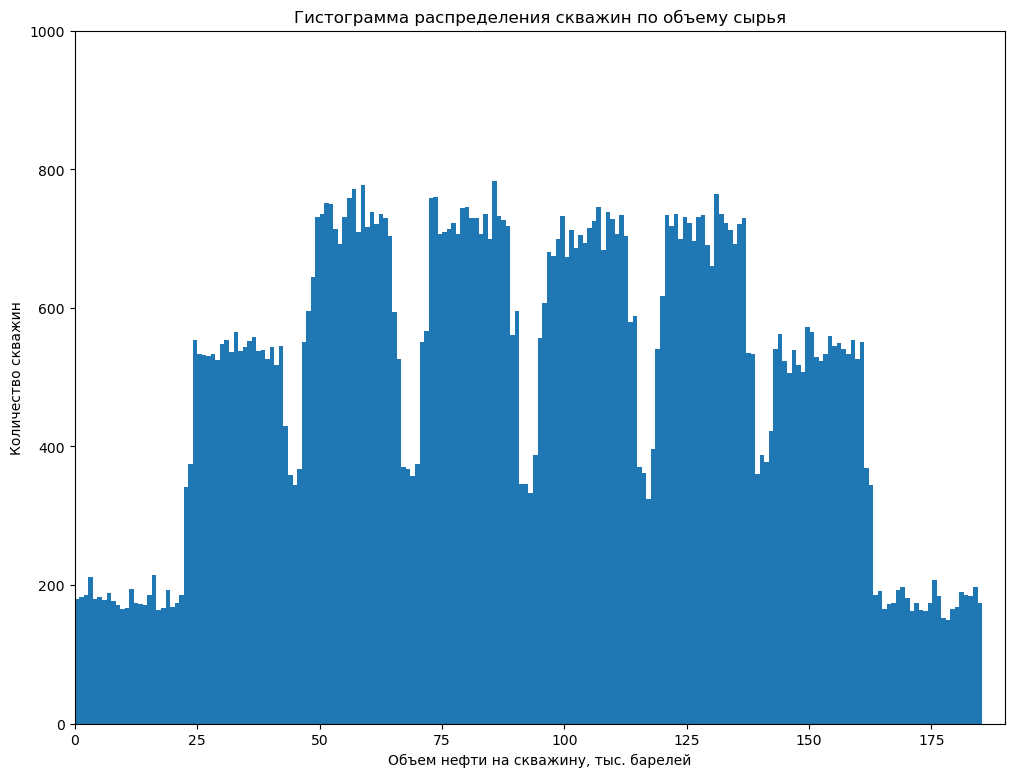

In [16]:
prod_hist(data['product'], 200, 190, 1000)

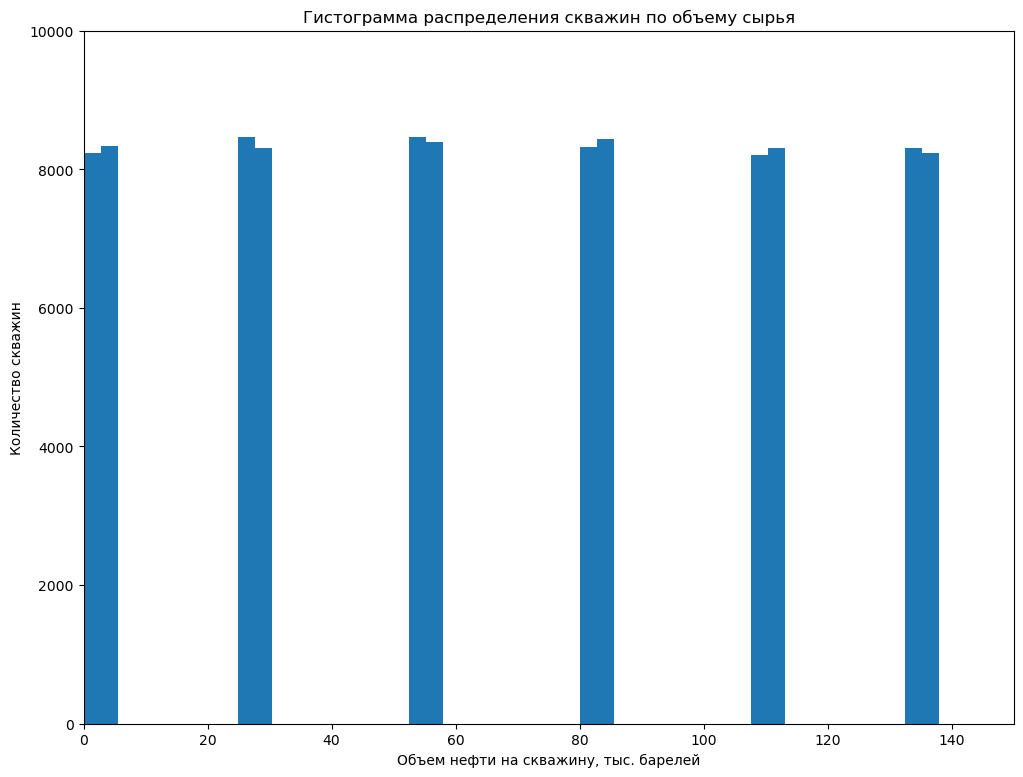

In [17]:
prod_hist(data_1['product'], 50, 150, 10000)

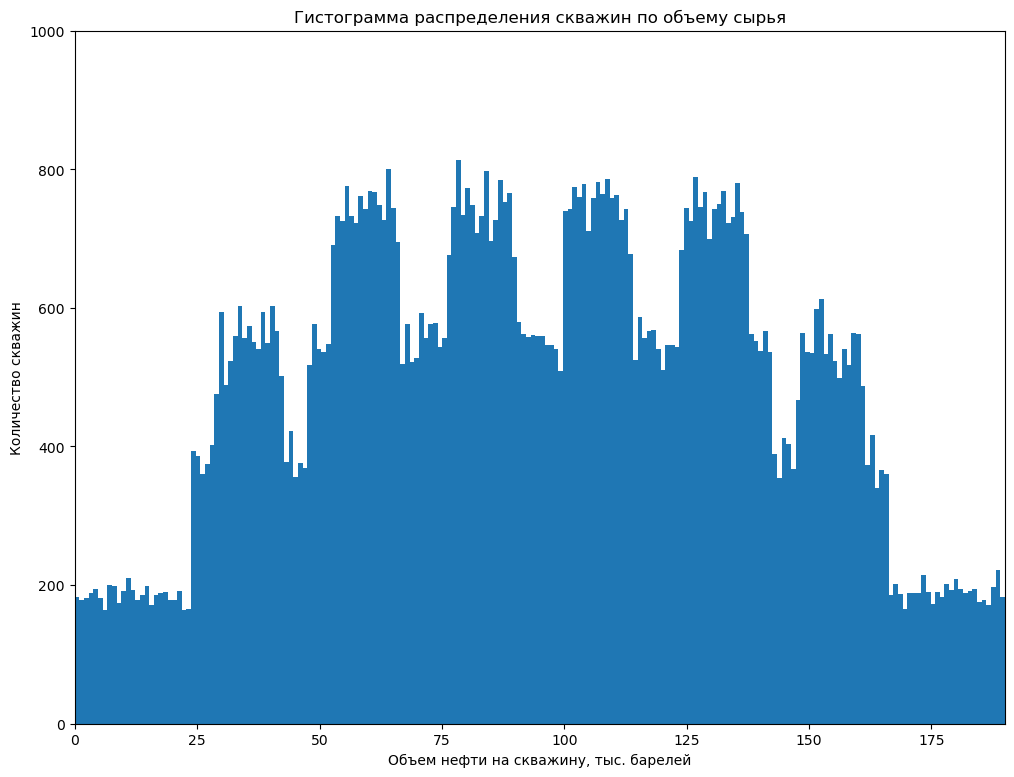

In [18]:
prod_hist(data_2['product'], 200, 190, 1000)

In [19]:
def split_df(df):
    # Выделим обучающие признаки и целевой признак product
    features = df.drop(columns=['product'])
    target = df['product']
    
    # Выборку нужно разбить на 2 части: обучающую и валидационную, в соотношении 75:25
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE
    )
    features_train = features_train.reset_index(drop=True)
    target_train = target_train.reset_index(drop=True)
    
    features_valid = features_valid.reset_index(drop=True)
    target_valid = target_valid.reset_index(drop=True)
    
    pd.options.mode.chained_assignment = None

    scaler = StandardScaler()
    scaler.fit(features_train)

    features_train = pd.DataFrame(scaler.transform(features_train))
    features_valid = pd.DataFrame(scaler.transform(features_valid))
   
    print(
        'размер features_train:', features_train.shape,
        '\nразмер target_train:', target_train.shape,
        '\nразмер features_valid:', features_valid.shape,
        '\nразмер target_valid:', target_valid.shape
    )
    return features_train, features_valid, target_train, target_valid

**Вывод:**

Данные готовы к обучению.

Признаки для модели:

- f0;
- f1;
- f2.

Целевой признак:

- product.

В месторождении №2(data_1) около 8,24% скважин имеют нулевые значения в столбце product. На первом и третьем месторождениях такое не наблюдается, можно предположить, что были утеряны данные или не было исследовано количество барелей нефти.

По гистограммам можно понять, что у первого и третьего месторождений распределение скважин близкое к нормальному. Во втором регионе данные имеют странное распределение: с шагом по 20-30 тыс.баррелей равномерно распределены 100000 значений. Данные скорее всего были введены искуственно.

## Обучение и проверка модели

In [20]:
def train_model(df):
    features_train, features_valid, target_train, target_valid = split_df(df)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = pd.Series(model.predict(features_valid), index=features_valid.index)
    
    print('\nRMSE: {:.2f}'.format(mean_squared_error(target_valid, predictions_valid) ** 0.5))
    print('Средний запас сырья на скважину, тыс. баррелей: {:.2f}'.format(predictions_valid.mean()))
    for_df = {'real_product' : target_valid,
            'predicted_product' : predictions_valid         
    }
    data_frame = pd.DataFrame(for_df, columns = ['real_product', 'predicted_product'])
    display(data_frame.head())
    
    return target_valid, predictions_valid

In [21]:
target_valid_0, predictions_valid_0 = train_model(data)

размер features_train: (74992, 3) 
размер target_train: (74992,) 
размер features_valid: (24998, 3) 
размер target_valid: (24998,)

RMSE: 37.85
Средний запас сырья на скважину, тыс. баррелей: 92.79


,real_product,predicted_product
0,123.566299,103.950372
1,63.442039,73.687869
2,88.718000,101.015288
3,51.422060,94.048415
4,102.569999,87.559552


In [22]:
target_valid_1, predictions_valid_1 = train_model(data_1)

размер features_train: (74997, 3) 
размер target_train: (74997,) 
размер features_valid: (24999, 3) 
размер target_valid: (24999,)

RMSE: 0.89
Средний запас сырья на скважину, тыс. баррелей: 68.96


,real_product,predicted_product
0,134.766305,135.287036
1,0.000000,0.250471
2,110.992147,110.164170
3,134.766305,135.096570
4,84.038886,84.068196


In [23]:
target_valid_2, predictions_valid_2 = train_model(data_2)

размер features_train: (74997, 3) 
размер target_train: (74997,) 
размер features_valid: (24999, 3) 
размер target_valid: (24999,)

RMSE: 40.04
Средний запас сырья на скважину, тыс. баррелей: 95.08


,real_product,predicted_product
0,52.610856,112.371168
1,64.974087,86.980341
2,73.344905,89.619331
3,103.609173,81.477383
4,102.806338,97.694581


Выводы:

- исходя из значений RMSE погрешность модели меньше всего для 2 региона
- среднее количество сырья примерно равно в 1 и 3 регионе, и больше примерно в 1.4 раза, чем во 2

## Подготовка к расчёту прибыли

In [24]:
# количество исследуемых точек при разведке
RESEARCH_POINTS = 500 

# количество лучших исследуемых точек 
BEST_RESEARCH_POINTS = 200 

# бюджет на разработку скважин в регионе
BUDGET = 10 * 1e9 

# цена за 1000 баррелей сырья
PRODUCT_PRICE = 1000 * 450

# максимальная вероятность убытков
MAX_LOSS = 0.025

# количество выборок для bootstrap 
BOOTSTRAP_SAMPLES = 1000 

# доверительный интервал 
CONF_INTERVAL = 0.95

In [25]:
budget_per_point = BUDGET / BEST_RESEARCH_POINTS
min_product = budget_per_point / PRODUCT_PRICE
print(
    'Минимальный объём сырья для безубыточной разработки новой скважины, тыс. баррелей: {:.2f}'
    .format(min_product)
)

Минимальный объём сырья для безубыточной разработки новой скважины, тыс. баррелей: 111.11


In [26]:
def calculate_profit(target_valid, predictions_valid):
    research_points = predictions_valid.sample(n=RESEARCH_POINTS, replace=True, random_state=RANDOM_STATE)
    best_research_points = research_points.sort_values(ascending = False)[:BEST_RESEARCH_POINTS]
    
    product_volume = target_valid[best_research_points.index].sum()
    
    profit = PRODUCT_PRICE * product_volume - BUDGET

    return profit, product_volume

Прибыль (млн. руб): 484.40 
Суммарный объем сырья (тыс. баррелей): 23298.67


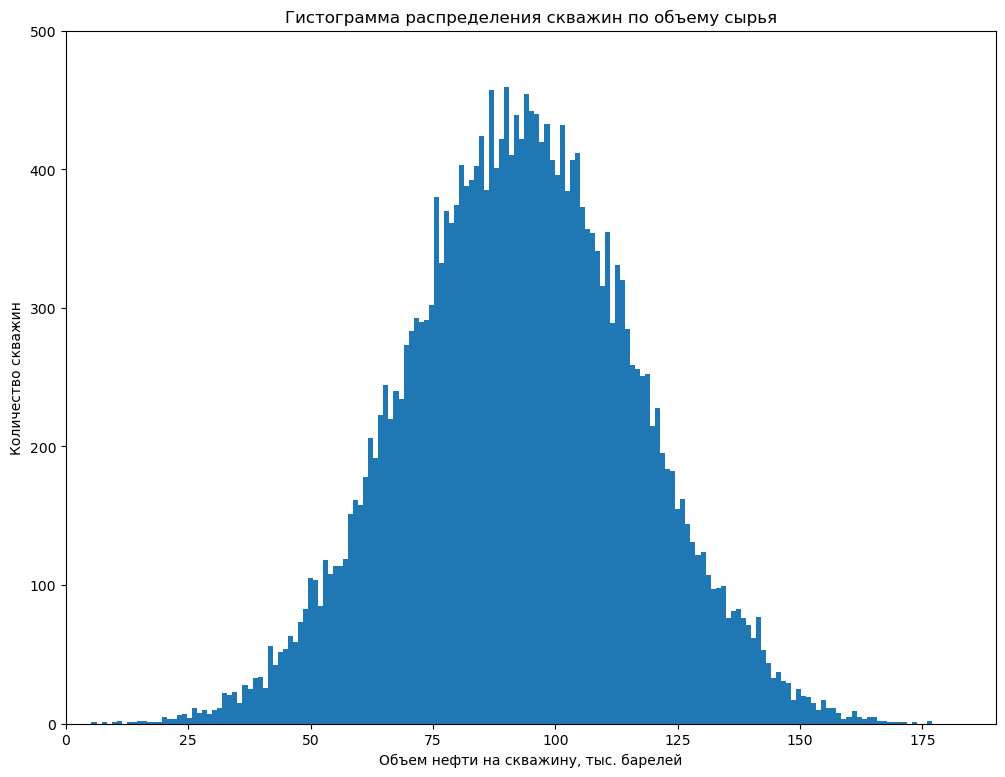

In [27]:
profit_0, product_volume_0 = calculate_profit(target_valid_0, predictions_valid_0)
    
print('Прибыль (млн. руб): {:.2f}'.format(to_mil(profit_0)),
    '\nСуммарный объем сырья (тыс. баррелей): {:.2f}'.format(product_volume_0)
)    
prod_hist(predictions_valid_0, 200, 190, 500)

Прибыль (млн. руб): 69.66 
Суммарный объем сырья (тыс. баррелей): 22377.01


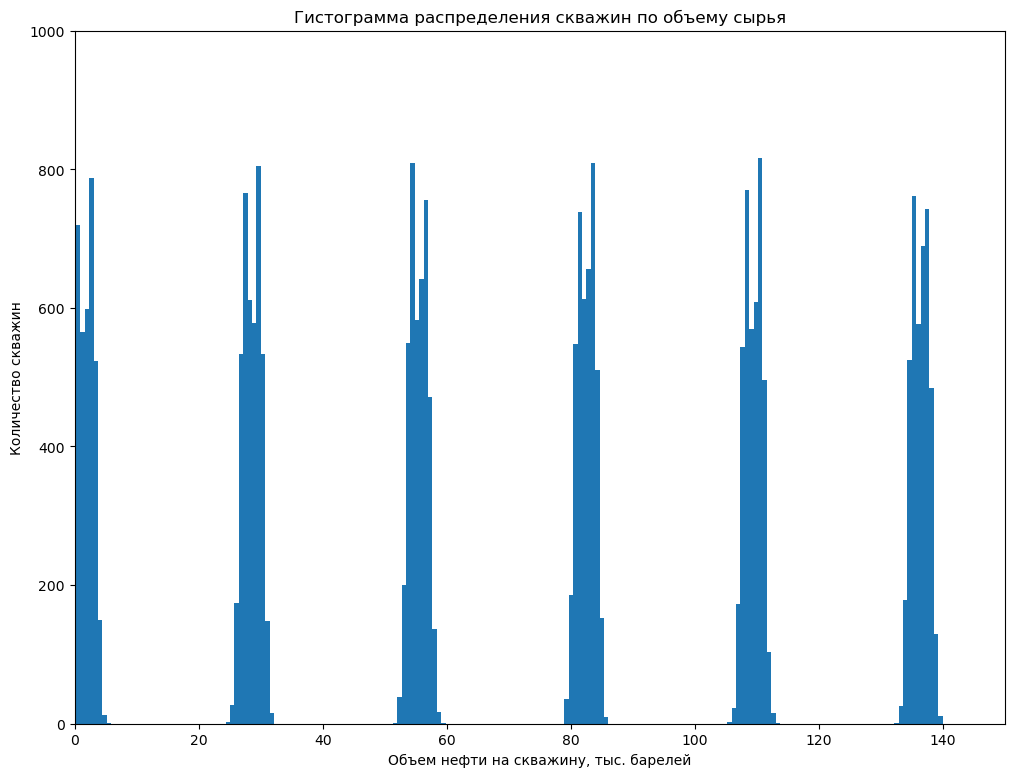

In [28]:
profit_1, product_volume_1 = calculate_profit(target_valid_1, predictions_valid_1)

print('Прибыль (млн. руб): {:.2f}'.format(to_mil(profit_1)),
    '\nСуммарный объем сырья (тыс. баррелей): {:.2f}'.format(product_volume_1)
)   
prod_hist(predictions_valid_1, 200, 150, 1000)

Прибыль (млн. руб): 428.46 
Суммарный объем сырья (тыс. баррелей): 23174.35


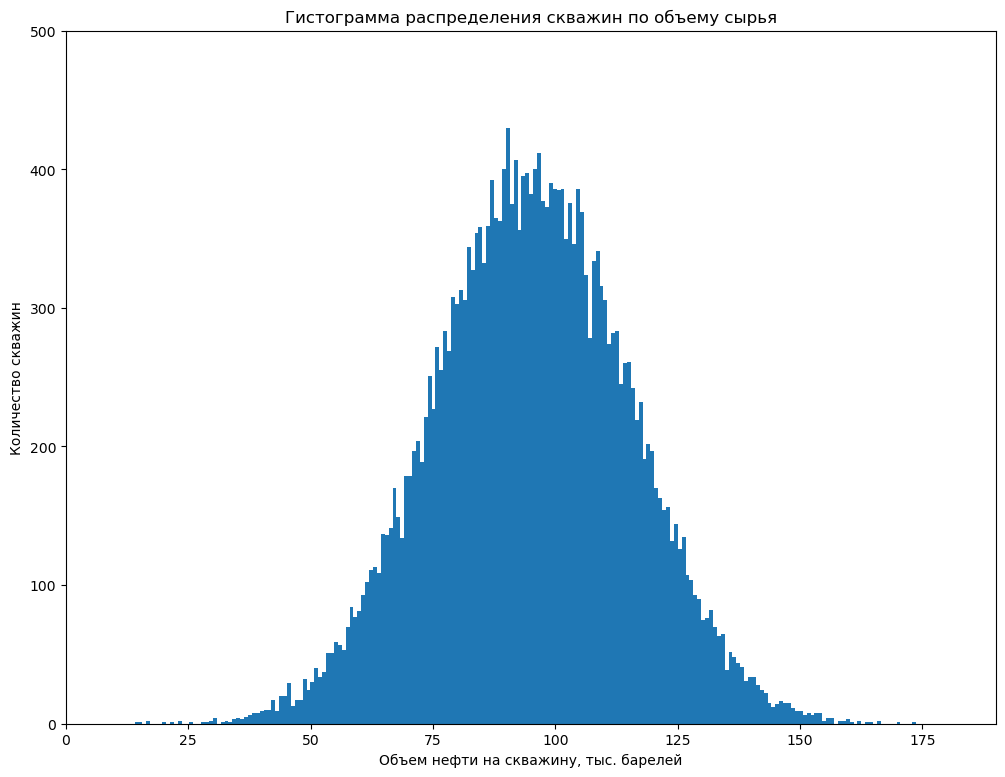

ValueError: DataFrame constructor not properly called!

In [38]:
profit_2, product_volume_2 = calculate_profit(target_valid_2, predictions_valid_2)

print('Прибыль (млн. руб): {:.2f}'.format(to_mil(profit_2)),
    '\nСуммарный объем сырья (тыс. баррелей): {:.2f}'.format(product_volume_2)
)
prod_hist(predictions_valid_2, 200, 190, 500)
profit_2 = pd.DataFrame(profit_2)
profit_2.hist()

## Расчёт прибыли и рисков 

In [30]:
def calculate_profit_bootstrap(target_valid, predictions_valid):
    values = []

    for i in range(BOOTSTRAP_SAMPLES): 
        profit, volume = calculate_profit(target_valid, predictions_valid)  
        values.append(profit)
        
    values = pd.Series(values)
    profit_mean = values.mean()

    conf_lower = values.quantile((1 - CONF_INTERVAL) / 2)
    conf_upper = values.quantile((1 + CONF_INTERVAL) / 2) 
    
    loss_probability = (values < 0).sum() / BOOTSTRAP_SAMPLES 
    
    print('Средняя прибыль (млн. руб): {:.2f}'.format(to_mil(profit_mean)))
    print(
        '95% доверительный интервал (млн. руб): ({:.2f}, {:.2f})'
        .format(to_mil(conf_lower), to_mil(conf_upper))
    )

    if loss_probability < MAX_LOSS: 
        print(
            'Риск убытков равен {:.2%}, что меньше чем максимально допустимого риска {:.2%}'
            .format(loss_probability, MAX_LOSS)
        )
    else:
        print(
            'Риск убытков равен {:.2%}, что больше чем максимально допустимого риска {:.2%}'
            .format(loss_probability, MAX_LOSS)
        )    

    return profit_mean, conf_lower, conf_upper, loss_probability

In [31]:
profit_and_risks = []

In [32]:
profit_and_risks.append(calculate_profit_bootstrap(target_valid_0, predictions_valid_0))

Средняя прибыль (млн. руб): 389.32
95% доверительный интервал (млн. руб): (-112.97, 894.00)
Риск убытков равен 7.40%, что больше чем максимально допустимого риска 2.50%


In [33]:
profit_and_risks.append(calculate_profit_bootstrap(target_valid_1, predictions_valid_1))

Средняя прибыль (млн. руб): 439.08
95% доверительный интервал (млн. руб): (33.06, 850.15)
Риск убытков равен 1.30%, что меньше чем максимально допустимого риска 2.50%


In [34]:
profit_and_risks.append(calculate_profit_bootstrap(target_valid_2, predictions_valid_2))

Средняя прибыль (млн. руб): 449.84
95% доверительный интервал (млн. руб): (-62.39, 943.66)
Риск убытков равен 4.60%, что больше чем максимально допустимого риска 2.50%


**Выводы:**

Из таблицы видно, что единственный регион, где вероятность убытков ниже, чем допустимое значение - второй (первый, если использовать индексацию с 0), поэтому для разработки скважин надо выбрать его.

Также у второго региона самый узкий доверительный интервал и самая выскокая средняя прибыль. Поэтому советовать для дальнейшей разработки можно только Регион 2(data_1).

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован